#**Importing the Libraries**

In [ ]:
!pip install flask flask-ngrok

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGB
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import pickle

#**Importing the Dataset**

In [ ]:
df = pd.read_csv('/content/Capstone Dataset.csv')
df.head(10)

,State,District,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Number of Households,Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Metro Present in 2025
0,Telangana,Adilabad,Medium,"649,849","2,741,239",11.0,16105.00,120.0,Inadequate,30.0,No,3.0,No
1,Uttar Pradesh,Agra,Medium,"710,566","4,418,797",20.0,4041.00,121.0,Sufficient,35.0,Yes,7.0,No
2,Gujarat,Ahmedabad,Medium,"1,510,134","7,214,225",19.0,8107.00,193.0,Inadequate,40.0,Yes,2.0,No
3,Maharashtra,Ahmednagar,Low,"930,024","4,543,159",16.0,17048.00,169.0,Inadequate,30.0,No,3.0,No
4,Mizoram,Aizawl,High,"82,524","400,309",23.0,3576.00,29.0,Inadequate,8.0,Yes,4.0,No
5,Rajasthan,Ajmer,Low,"494,832","2,583,052",21.0,8481.00,112.0,Sufficient,17.0,Yes,6.0,Yes
6,Maharashtra,Akola,Low,"395,690","1,813,906",16.0,5672.81,120.0,Overburdened,30.0,No,2.0,No
7,Kerala,Alappuzha,Medium,"535,958","2,127,789",5.0,1415.00,48.0,Inadequate,25.0,Yes,4.0,No
8,Uttar Pradesh,Aligarh,Medium,"611,371","3,673,889",20.0,3650.00,98.0,Sufficient,13.0,Yes,6.0,Yes
9,Madhya Pradesh,Alirajpur,Low,"123,800","728,999",20.0,3182.00,177.0,Sufficient,30.0,No,2.0,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 13 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   State                                                         628 non-null    object 
 1   District                                                      628 non-null    object 
 2   Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)  628 non-null    object 
 3   Number of Households                                          628 non-null    object 
 4   Population                                                    628 non-null    object 
 5   Decadal Growth Rate in % (2001-2011)                          628 non-null    float64
 6   Area (in sq km)                                               628 non-null    float64
 7   AQI                                                           628 non-n

In [ ]:
df.isnull().sum()

,0
State,44
District,44
Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),44
Number of Households,44
Population,44
Decadal Growth Rate in % (2001-2011),44
Area (in sq km),44
AQI,44
Current Infrastructure,44
Average Commute Time,44


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isnull().sum()

,0
State,0
District,0
Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),0
Number of Households,0
Population,0
Decadal Growth Rate in % (2001-2011),0
Area (in sq km),0
AQI,0
Current Infrastructure,0
Average Commute Time,0


In [ ]:
df.shape

(628, 13)

#**Data Preprocessing**

In [ ]:
df['Number of Households'] = df['Number of Households'].astype(str).str.replace(',', '').astype(int)
df['Population'] = df['Population'].astype(str).str.replace(',', '').astype(int)
df['Area (in sq km)'] = df['Area (in sq km)'].astype(str).str.replace(',', '').astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   State                                                         628 non-null    object 
 1   District                                                      628 non-null    object 
 2   Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)  628 non-null    object 
 3   Number of Households                                          628 non-null    int64  
 4   Population                                                    628 non-null    int64  
 5   Decadal Growth Rate in % (2001-2011)                          628 non-null    float64
 6   Area (in sq km)                                               628 non-null    float64
 7   AQI                                                           628 non-null  

In [ ]:
df.head(10)

,State,District,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Number of Households,Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Metro Present in 2025
0,Telangana,Adilabad,Medium,649849,2741239,11.0,16105.00,120.0,Inadequate,30.0,No,3.0,No
1,Uttar Pradesh,Agra,Medium,710566,4418797,20.0,4041.00,121.0,Sufficient,35.0,Yes,7.0,No
2,Gujarat,Ahmedabad,Medium,1510134,7214225,19.0,8107.00,193.0,Inadequate,40.0,Yes,2.0,No
3,Maharashtra,Ahmednagar,Low,930024,4543159,16.0,17048.00,169.0,Inadequate,30.0,No,3.0,No
4,Mizoram,Aizawl,High,82524,400309,23.0,3576.00,29.0,Inadequate,8.0,Yes,4.0,No
5,Rajasthan,Ajmer,Low,494832,2583052,21.0,8481.00,112.0,Sufficient,17.0,Yes,6.0,Yes
6,Maharashtra,Akola,Low,395690,1813906,16.0,5672.81,120.0,Overburdened,30.0,No,2.0,No
7,Kerala,Alappuzha,Medium,535958,2127789,5.0,1415.00,48.0,Inadequate,25.0,Yes,4.0,No
8,Uttar Pradesh,Aligarh,Medium,611371,3673889,20.0,3650.00,98.0,Sufficient,13.0,Yes,6.0,Yes
9,Madhya Pradesh,Alirajpur,Low,123800,728999,20.0,3182.00,177.0,Sufficient,30.0,No,2.0,No


#**Data Visualisation**

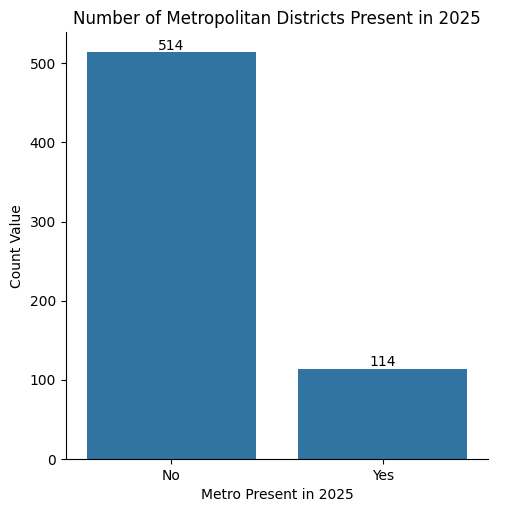

In [ ]:
plot = sns.catplot(data=df, x='Metro Present in 2025', kind='count')

ax = plot.ax

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center', va='bottom')

ax.set_xlabel('Metro Present in 2025')
ax.set_ylabel('Count Value')
ax.set_title('Number of Metropolitan Districts Present in 2025')

plt.show()

#**Encoding the Features**

In [ ]:
df.drop(columns= ['State', 'District'], axis= 1, inplace= True)

In [ ]:
df.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Number of Households,Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Metro Present in 2025
0,Medium,649849,2741239,11.0,16105.00,120.0,Inadequate,30.0,No,3.0,No
1,Medium,710566,4418797,20.0,4041.00,121.0,Sufficient,35.0,Yes,7.0,No
2,Medium,1510134,7214225,19.0,8107.00,193.0,Inadequate,40.0,Yes,2.0,No
3,Low,930024,4543159,16.0,17048.00,169.0,Inadequate,30.0,No,3.0,No
4,High,82524,400309,23.0,3576.00,29.0,Inadequate,8.0,Yes,4.0,No
5,Low,494832,2583052,21.0,8481.00,112.0,Sufficient,17.0,Yes,6.0,Yes
6,Low,395690,1813906,16.0,5672.81,120.0,Overburdened,30.0,No,2.0,No
7,Medium,535958,2127789,5.0,1415.00,48.0,Inadequate,25.0,Yes,4.0,No
8,Medium,611371,3673889,20.0,3650.00,98.0,Sufficient,13.0,Yes,6.0,Yes
9,Low,123800,728999,20.0,3182.00,177.0,Sufficient,30.0,No,2.0,No


In [ ]:
df['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)'] = df['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)'].map({'Low': 0, 'Medium': 1, 'High': 2})
df['Current Infrastructure'] = df['Current Infrastructure'].map({'Inadequate': 0, 'Overburdened': 1, 'Sufficient': 2})

In [ ]:
df['Connectivity to Airport (within 100 kms)'] = df['Connectivity to Airport (within 100 kms)'].map({'No': False, 'Yes': True})

In [ ]:
df.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Number of Households,Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Metro Present in 2025
0,1,649849,2741239,11.0,16105.00,120.0,0,30.0,False,3.0,No
1,1,710566,4418797,20.0,4041.00,121.0,2,35.0,True,7.0,No
2,1,1510134,7214225,19.0,8107.00,193.0,0,40.0,True,2.0,No
3,0,930024,4543159,16.0,17048.00,169.0,0,30.0,False,3.0,No
4,2,82524,400309,23.0,3576.00,29.0,0,8.0,True,4.0,No
5,0,494832,2583052,21.0,8481.00,112.0,2,17.0,True,6.0,Yes
6,0,395690,1813906,16.0,5672.81,120.0,1,30.0,False,2.0,No
7,1,535958,2127789,5.0,1415.00,48.0,0,25.0,True,4.0,No
8,1,611371,3673889,20.0,3650.00,98.0,2,13.0,True,6.0,Yes
9,0,123800,728999,20.0,3182.00,177.0,2,30.0,False,2.0,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)  628 non-null    int64  
 1   Number of Households                                          628 non-null    int64  
 2   Population                                                    628 non-null    int64  
 3   Decadal Growth Rate in % (2001-2011)                          628 non-null    float64
 4   Area (in sq km)                                               628 non-null    float64
 5   AQI                                                           628 non-null    float64
 6   Current Infrastructure                                        628 non-null    int64  
 7   Average Commute Time                                          628 non-null  

#**Label Encoding**

In [ ]:
le = LabelEncoder()
df['Metro Present in 2025'] = le.fit_transform(df['Metro Present in 2025'])

In [ ]:
df.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Number of Households,Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Metro Present in 2025
0,1,649849,2741239,11.0,16105.00,120.0,0,30.0,False,3.0,0
1,1,710566,4418797,20.0,4041.00,121.0,2,35.0,True,7.0,0
2,1,1510134,7214225,19.0,8107.00,193.0,0,40.0,True,2.0,0
3,0,930024,4543159,16.0,17048.00,169.0,0,30.0,False,3.0,0
4,2,82524,400309,23.0,3576.00,29.0,0,8.0,True,4.0,0
5,0,494832,2583052,21.0,8481.00,112.0,2,17.0,True,6.0,1
6,0,395690,1813906,16.0,5672.81,120.0,1,30.0,False,2.0,0
7,1,535958,2127789,5.0,1415.00,48.0,0,25.0,True,4.0,0
8,1,611371,3673889,20.0,3650.00,98.0,2,13.0,True,6.0,1
9,0,123800,728999,20.0,3182.00,177.0,2,30.0,False,2.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 627
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)  628 non-null    int64  
 1   Number of Households                                          628 non-null    int64  
 2   Population                                                    628 non-null    int64  
 3   Decadal Growth Rate in % (2001-2011)                          628 non-null    float64
 4   Area (in sq km)                                               628 non-null    float64
 5   AQI                                                           628 non-null    float64
 6   Current Infrastructure                                        628 non-null    int64  
 7   Average Commute Time                                          628 non-null  

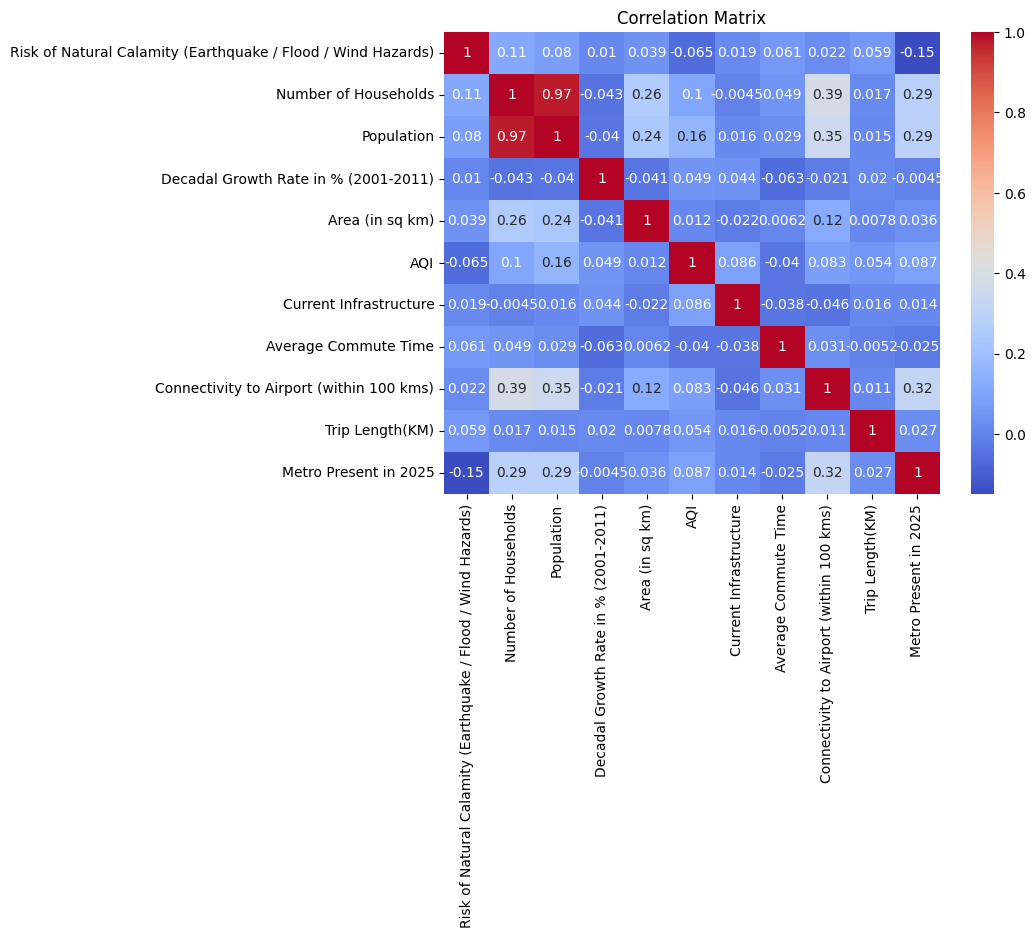

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Creating a derived feature "Population Density" to eliminate corelation**

In [ ]:
df['Population Density'] = df['Population'] / df['Area (in sq km)']
df['Population Density'] = df['Population Density'].round(2)

In [ ]:
df.drop(columns=['Number of Households'], axis=1, inplace=True)
df = df[['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Population',
 'Decadal Growth Rate in % (2001-2011)',
 'Area (in sq km)',
 'AQI',
 'Current Infrastructure',
 'Average Commute Time',
 'Connectivity to Airport (within 100 kms)',
 'Trip Length(KM)', 'Population Density',
 'Metro Present in 2025'
 ]]
df.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Population Density,Metro Present in 2025
0,1,2741239,11.0,16105.00,120.0,0,30.0,False,3.0,170.21,0
1,1,4418797,20.0,4041.00,121.0,2,35.0,True,7.0,1093.49,0
2,1,7214225,19.0,8107.00,193.0,0,40.0,True,2.0,889.88,0
3,0,4543159,16.0,17048.00,169.0,0,30.0,False,3.0,266.49,0
4,2,400309,23.0,3576.00,29.0,0,8.0,True,4.0,111.94,0
5,0,2583052,21.0,8481.00,112.0,2,17.0,True,6.0,304.57,1
6,0,1813906,16.0,5672.81,120.0,1,30.0,False,2.0,319.75,0
7,1,2127789,5.0,1415.00,48.0,0,25.0,True,4.0,1503.74,0
8,1,3673889,20.0,3650.00,98.0,2,13.0,True,6.0,1006.54,1
9,0,728999,20.0,3182.00,177.0,2,30.0,False,2.0,229.10,0


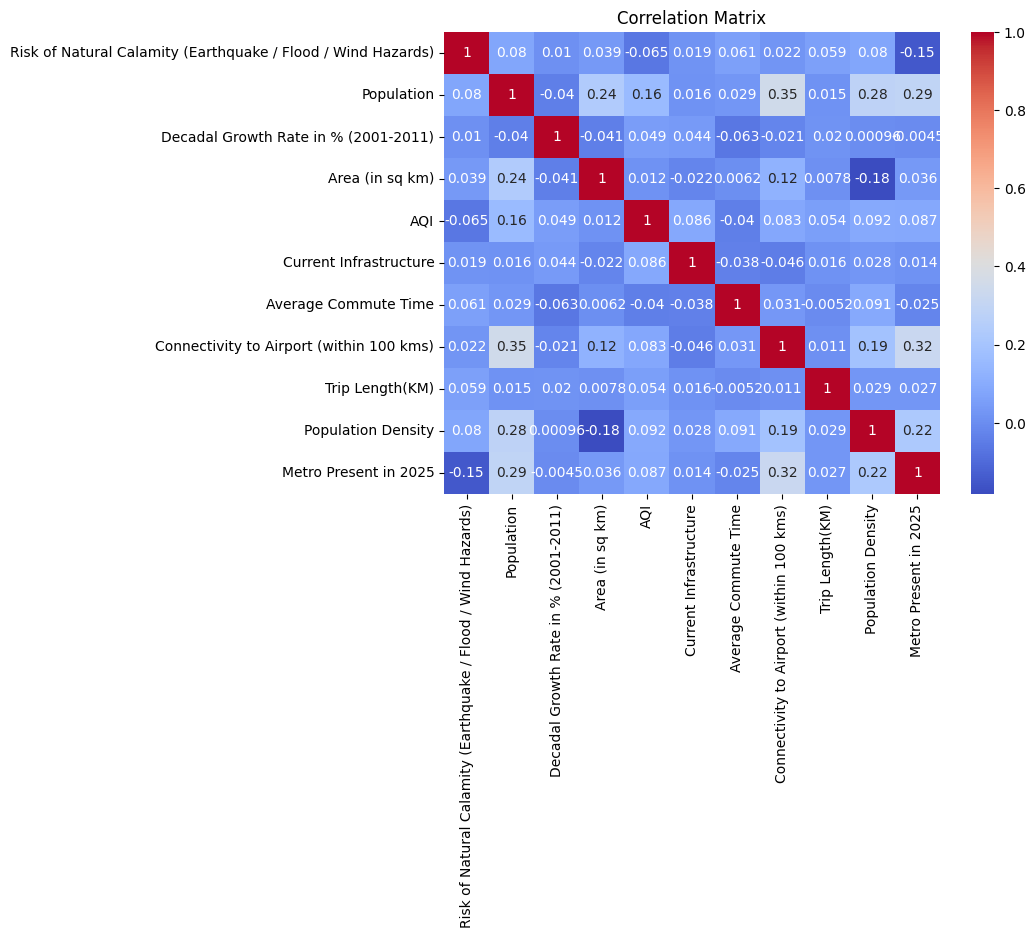

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df.shape

(628, 11)

In [ ]:
df.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Population Density,Metro Present in 2025
0,1,2741239,11.0,16105.00,120.0,0,30.0,False,3.0,170.21,0
1,1,4418797,20.0,4041.00,121.0,2,35.0,True,7.0,1093.49,0
2,1,7214225,19.0,8107.00,193.0,0,40.0,True,2.0,889.88,0
3,0,4543159,16.0,17048.00,169.0,0,30.0,False,3.0,266.49,0
4,2,400309,23.0,3576.00,29.0,0,8.0,True,4.0,111.94,0
5,0,2583052,21.0,8481.00,112.0,2,17.0,True,6.0,304.57,1
6,0,1813906,16.0,5672.81,120.0,1,30.0,False,2.0,319.75,0
7,1,2127789,5.0,1415.00,48.0,0,25.0,True,4.0,1503.74,0
8,1,3673889,20.0,3650.00,98.0,2,13.0,True,6.0,1006.54,1
9,0,728999,20.0,3182.00,177.0,2,30.0,False,2.0,229.10,0


#**Augmenting the Dataset**

In [ ]:
features = df.columns[:-1].tolist()
features

['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Population',
 'Decadal Growth Rate in % (2001-2011)',
 'Area (in sq km)',
 'AQI',
 'Current Infrastructure',
 'Average Commute Time',
 'Connectivity to Airport (within 100 kms)',
 'Trip Length(KM)',
 'Population Density']

In [ ]:
yes_cases = df[df['Metro Present in 2025'] == 1]
augmented_cases = yes_cases.copy()

for col in features:
  augmented_cases[col] += np.random.uniform(-30, 50, size=len(2*augmented_cases))

df = pd.concat([df, augmented_cases], ignore_index=True)
print(f"Dataset shape after augmentation: {df.shape}")

Dataset shape after augmentation: (742, 11)


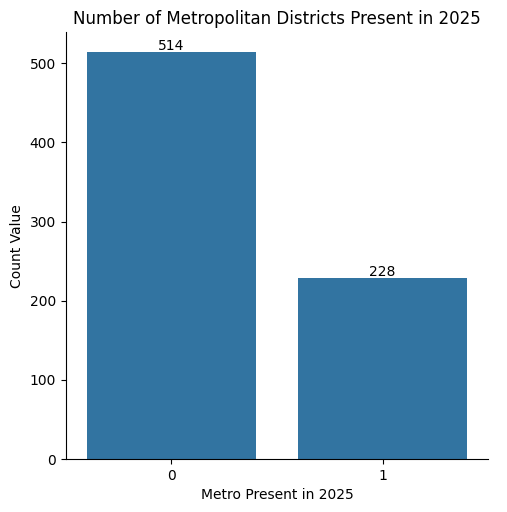

In [ ]:
plot = sns.catplot(data=df, x='Metro Present in 2025', kind='count')

ax = plot.ax

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center', va='bottom')

ax.set_xlabel('Metro Present in 2025')
ax.set_ylabel('Count Value')
ax.set_title('Number of Metropolitan Districts Present in 2025')

plt.show()

#**X-Y Split**

In [ ]:
x = df.drop(columns=['Metro Present in 2025'])
x.head(10)

,Risk of Natural Calamity (Earthquake / Flood / Wind Hazards),Population,Decadal Growth Rate in % (2001-2011),Area (in sq km),AQI,Current Infrastructure,Average Commute Time,Connectivity to Airport (within 100 kms),Trip Length(KM),Population Density
0,1.0,2741239.0,11.0,16105.00,120.0,0.0,30.0,0.0,3.0,170.21
1,1.0,4418797.0,20.0,4041.00,121.0,2.0,35.0,1.0,7.0,1093.49
2,1.0,7214225.0,19.0,8107.00,193.0,0.0,40.0,1.0,2.0,889.88
3,0.0,4543159.0,16.0,17048.00,169.0,0.0,30.0,0.0,3.0,266.49
4,2.0,400309.0,23.0,3576.00,29.0,0.0,8.0,1.0,4.0,111.94
5,0.0,2583052.0,21.0,8481.00,112.0,2.0,17.0,1.0,6.0,304.57
6,0.0,1813906.0,16.0,5672.81,120.0,1.0,30.0,0.0,2.0,319.75
7,1.0,2127789.0,5.0,1415.00,48.0,0.0,25.0,1.0,4.0,1503.74
8,1.0,3673889.0,20.0,3650.00,98.0,2.0,13.0,1.0,6.0,1006.54
9,0.0,728999.0,20.0,3182.00,177.0,2.0,30.0,0.0,2.0,229.10


In [ ]:
y = df['Metro Present in 2025']
y.head(10)

,Metro Present in 2025
0,0
1,0
2,0
3,0
4,0
5,1
6,0
7,0
8,1
9,0


#**Feature Selection**

##**Decision Tree Classifier**

In [ ]:
dtc_estimator = DecisionTreeClassifier(random_state=42)

In [ ]:
dtc_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfecv_dtc = RFECV(
    estimator=dtc_estimator,
    step=1,
    cv=dtc_cv,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
rfecv_dtc.fit(x, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
      scoring='f1')

In [ ]:
feature_ranks_dtc = list(zip(x.columns, rfecv_dtc.ranking_))
feature_ranks_dtc.sort(key=lambda x: x[1])

In [ ]:
dtc_selected_features = []
for i in range(5):
  dtc_selected_features.append(feature_ranks_dtc[i][0])
print(f"Decision Tree Classifier : \n{dtc_selected_features}")

Decision Tree Classifier : 
['Population', 'Area (in sq km)', 'Average Commute Time', 'Connectivity to Airport (within 100 kms)', 'AQI']


**After building 5 different Decision Tree Classifier Models, we conclude that the best features were: ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'Area (in sq km)', 'AQI']**

In [ ]:
dtc_best_model_features = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'Area (in sq km)', 'AQI']

##**Random Forest Classifier**

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)

In [ ]:
rf_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfecv_rf = RFECV(
    estimator=rf_estimator,
    step=1,
    cv=rf_cv,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
rfecv_rf.fit(x, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
      scoring='f1')

In [ ]:
feature_ranks_rfc = list(zip(x.columns, rfecv_rf.ranking_))
feature_ranks_rfc.sort(key=lambda x: x[1])

In [ ]:
rfc_selected_features = []
for i in range(5):
  rfc_selected_features.append(feature_ranks_rfc[i][0])
print(f"Random Forest Classifier : \n{rfc_selected_features}")

Random Forest Classifier : 
['Population', 'Decadal Growth Rate in % (2001-2011)', 'Average Commute Time', 'Connectivity to Airport (within 100 kms)', 'Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)']


**After building 5 different Random Forest Classifier Models, we conclude that the best features were: ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Average Commute Time', 'Connectivity to Airport (within 100 kms)', 'Trip Length(KM)']**

In [ ]:
rfc_best_model_features = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Average Commute Time', 'Connectivity to Airport (within 100 kms)', 'Trip Length(KM)']

##**XG Boost Classifier**

In [ ]:
xgb_estimator = XGB(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [ ]:
xgb_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfecv_xgb = RFECV(
    estimator=xgb_estimator,
    step=1,
    cv=xgb_cv,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
rfecv_xgb.fit(x, y)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='logloss',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...),
      n_jobs=-1, scoring='f1')

In [ ]:
feature_ranks_xgb = list(zip(x.columns, rfecv_xgb.ranking_))
feature_ranks_xgb.sort(key=lambda x: x[1])

In [ ]:
xgb_selected_features = []
for i in range(5):
  xgb_selected_features.append(feature_ranks_xgb[i][0])
print(f"XGB Classifier : \n{xgb_selected_features}")

XGB Classifier : 
['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'Area (in sq km)', 'AQI']


**After building 5 different XGBoost Models, we conclude that the best features were: ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'Area (in sq km)', 'AQI']**

In [ ]:
xgb_best_model_features = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'Area (in sq km)', 'AQI']

##**Logistic Regression**

In [ ]:
lr_estimator = LogisticRegression(solver='liblinear', random_state=42)

In [ ]:
lr_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfecv_lr = RFECV(
    estimator=lr_estimator,
    step=1,
    cv=lr_cv,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
rfecv_lr.fit(x, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(random_state=42, solver='liblinear'),
      n_jobs=-1, scoring='f1')

In [ ]:
feature_ranks_svm = list(zip(x.columns, rfecv_lr.ranking_))
feature_ranks_svm.sort(key=lambda x: x[1])

In [ ]:
logreg_selected_features = []
for i in range(5):
  logreg_selected_features.append(feature_ranks_svm[i][0])
print(f"Logistic Regression:\n{logreg_selected_features}")

Logistic Regression:
['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Decadal Growth Rate in % (2001-2011)', 'AQI', 'Current Infrastructure', 'Average Commute Time']


**After building 5 different Logistic Regression Models, we conclude that the best features were: ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Decadal Growth Rate in % (2001-2011)', 'AQI', 'Current Infrastructure', 'Average Commute Time']**

In [ ]:
logreg_best_model_features = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Decadal Growth Rate in % (2001-2011)', 'AQI', 'Current Infrastructure', 'Average Commute Time']

##**Non-Linear SVM**

In [ ]:
bool_cols = ['Connectivity to Airport (within 100 kms)']
num_cols = [col for col in x.columns if col not in bool_cols]

In [ ]:
svm_scaler = StandardScaler()
x_num_scaled =svm_scaler.fit_transform(x[num_cols])
x_bool = x[bool_cols].values

In [ ]:
x_scaled_for_rfe = np.hstack((x_num_scaled, x_bool))

In [ ]:
x_scaled_cols = num_cols + bool_cols

In [ ]:
svc = SVC(kernel='linear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
rfecv_svm = RFECV(
    estimator=svc,
    step=1,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

In [ ]:
rfecv_svm.fit(x_scaled_for_rfe, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=SVC(kernel='linear', random_state=42), n_jobs=-1, scoring='f1')

In [ ]:
feature_ranks_svm = list(zip(x.columns, rfecv_svm.ranking_))
feature_ranks_svm.sort(key=lambda x: x[1])

In [ ]:
svm_selected_features = []
for i in range(5):
  svm_selected_features.append(feature_ranks_svm[i][0])
print(f"Non-Linear SVM:\n{svm_selected_features}")

Non-Linear SVM:
['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Decadal Growth Rate in % (2001-2011)', 'Current Infrastructure', 'Connectivity to Airport (within 100 kms)', 'Trip Length(KM)']


**After building 5 different Support Vector Machines, along with different kernels, we conclude that the best features were: ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'AQI', 'Current Infrastructure']**

In [ ]:
svm_best_model_features = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)', 'Population', 'Decadal Growth Rate in % (2001-2011)', 'AQI', 'Current Infrastructure']

#**Train-Test Split and Model Building**

In [ ]:
def train_test_splitting(x, y):
    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size = 0.3,
        stratify = y,
        random_state = 42
    )

    return x_train, x_test, y_train, y_test

In [ ]:
def add_gaussian_noise(data, noise_level=0.01, seed=42):
    np.random.seed(seed)
    noisy_data = data + np.random.normal(0, noise_level, data.shape)
    return noisy_data

In [ ]:
smote = SMOTETomek(sampling_strategy='auto', random_state=42)

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)

In [ ]:
x['Connectivity to Airport (within 100 kms)'] = x['Connectivity to Airport (within 100 kms)'].astype(int)

##**XGBoost Model Building**

In [ ]:
xgb_x_train, xgb_x_test, xgb_y_train, xgb_y_test = train_test_splitting(
    x = x[xgb_best_model_features],
    y = y)

In [ ]:
xgb_bool_cols = ['Connectivity to Airport (within 100 kms)']
xgb_num_cols = [col for col in xgb_best_model_features if col not in bool_cols]
xgb_num_cols

['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Population',
 'Decadal Growth Rate in % (2001-2011)',
 'Area (in sq km)',
 'AQI']

In [ ]:
bool_cols_present = [col for col in xgb_bool_cols if col in xgb_best_model_features]
bool_cols_present

[]

In [ ]:
xgb_scaler = StandardScaler()

In [ ]:
xgb_x_train_num = xgb_scaler.fit_transform(xgb_x_train[xgb_num_cols])
xgb_x_test_num = xgb_scaler.transform(xgb_x_test[xgb_num_cols])

In [ ]:
if bool_cols_present:
    xgb_x_train_bool = xgb_x_train[bool_cols_present].values
    xgb_x_test_bool = xgb_x_test[bool_cols_present].values

    xgb_x_train_scaled = np.hstack((xgb_x_train_num, xgb_x_train_bool))
    xgb_x_test_scaled = np.hstack((xgb_x_test_num, xgb_x_test_bool))
else:
    xgb_x_train_scaled = xgb_x_train_num
    xgb_x_test_scaled = xgb_x_test_num

In [ ]:
xgb_x_train_res, xgb_y_train_res = smote.fit_resample(xgb_x_train_scaled, xgb_y_train)
xgb_x_train_res, xgb_y_train_res = undersample.fit_resample(xgb_x_train_res, xgb_y_train_res)

In [ ]:
xgb_x_train_synthetic = add_gaussian_noise(xgb_x_train_res, noise_level=0.05)
xgb_y_train_synthetic = xgb_y_train_res.copy()

In [ ]:
xgb_x_train_final = np.vstack((xgb_x_train_res, xgb_x_train_synthetic))
xgb_y_train_final = np.hstack((xgb_y_train_res, xgb_y_train_synthetic))

In [ ]:
print("Final class balance:", Counter(xgb_y_train_final))

Final class balance: Counter({np.int64(0): 686, np.int64(1): 686})


In [ ]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(xgb_y_train_final), y=xgb_y_train_final)
class_weight_ratio = weights[1] / weights[0]

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [class_weight_ratio, 1, 2, 3, 5, 10]
}

In [ ]:
xgb_base = XGB(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

In [ ]:
xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

In [ ]:
xgb_search.fit(xgb_x_train_final, xgb_y_train_final)
xgb_best_model = xgb_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("Best Parameters:", xgb_search.best_params_)

Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


**After training 5 different models, we found the following to be the best parameters and will be continuing with it:{'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}**

In [ ]:
xgb_best_model = XGB(
    subsample = 0.8,
    scale_pos_weight = 10,
    n_estimators = 300,
    max_depth = 7,
    learning_rate = 0.1,
    colsample_bytree = 1,
    random_state = 42,
    use_label_encoder = False,
    eval_metric = 'logloss'
)

In [ ]:
xgb_best_model.fit(xgb_x_train_final, xgb_y_train_final)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
calibrated_model = CalibratedClassifierCV(xgb_best_model, cv=5)
calibrated_model.fit(xgb_x_train_final, xgb_y_train_final)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:23:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

CalibratedClassifierCV(cv=5,
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1, device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric='logloss',
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=300, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=42, ...))

In [ ]:
y_probs_xgb = calibrated_model.predict_proba(xgb_x_test_scaled)[:, 1]

In [ ]:
thresholds = np.arange(0.3, 0.71, 0.01)

best_f1 = 0
best_thresh = 0
best_metrics = (0, 0)

f1s = []
precisions = []
recalls = []

for thresh in thresholds:
    preds = (y_probs_xgb > thresh).astype(int)
    precision = precision_score(xgb_y_test, preds)
    recall = recall_score(xgb_y_test, preds)
    f1 = f1_score(xgb_y_test, preds)

    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
        best_metrics = (precision, recall)

print(f"\nBest F1 Score: {best_f1:.4f} at threshold: {best_thresh:.2f}")
print(f"Precision of Yes Cases: {best_metrics[0]:.4f}, Recall of Yes Cases: {best_metrics[1]:.4f}")


Best F1 Score: 0.6154 at threshold: 0.70
Precision of Yes Cases: 0.6557, Recall of Yes Cases: 0.5797


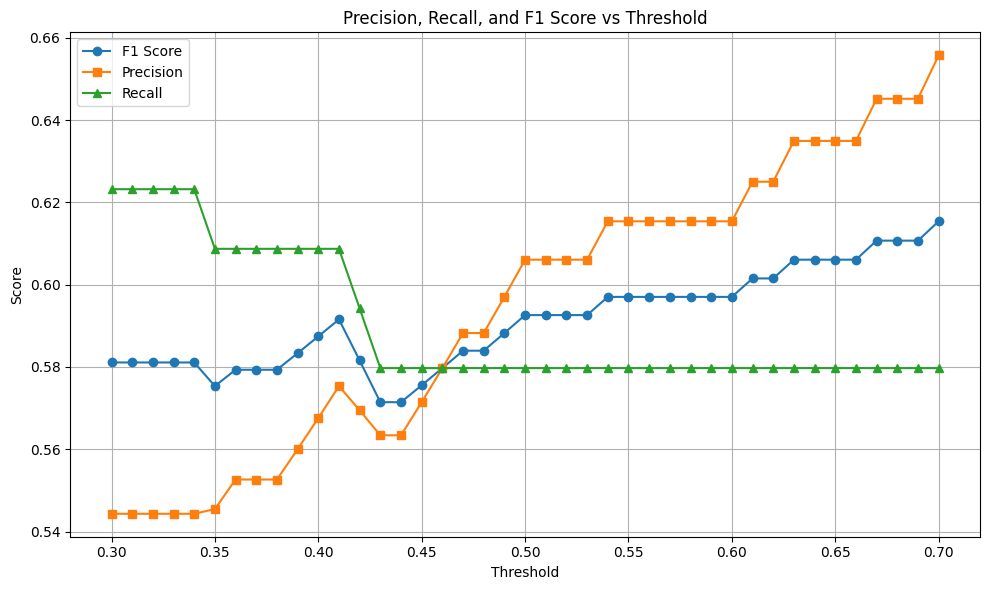

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.plot(thresholds, recalls, label='Recall', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
xgb_final_preds = (y_probs_xgb > best_thresh).astype(int)

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(xgb_y_test, xgb_final_preds))


Confusion Matrix:
[[133  21]
 [ 29  40]]


In [ ]:
print("\nClassification Report:")
print(classification_report(xgb_y_test, xgb_final_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       154
           1       0.66      0.58      0.62        69

    accuracy                           0.78       223
   macro avg       0.74      0.72      0.73       223
weighted avg       0.77      0.78      0.77       223



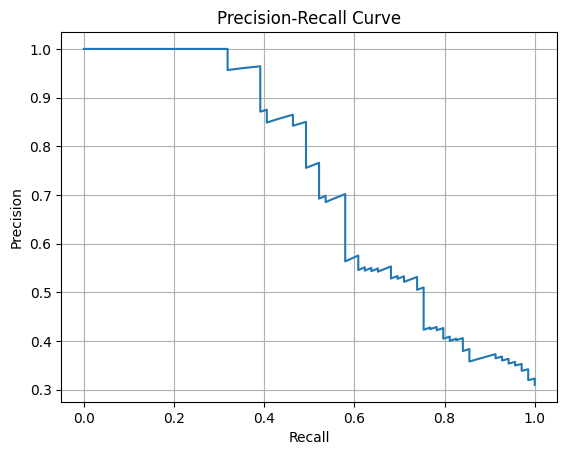

In [ ]:
precision, recall, thresholds = precision_recall_curve(xgb_y_test, y_probs_xgb)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

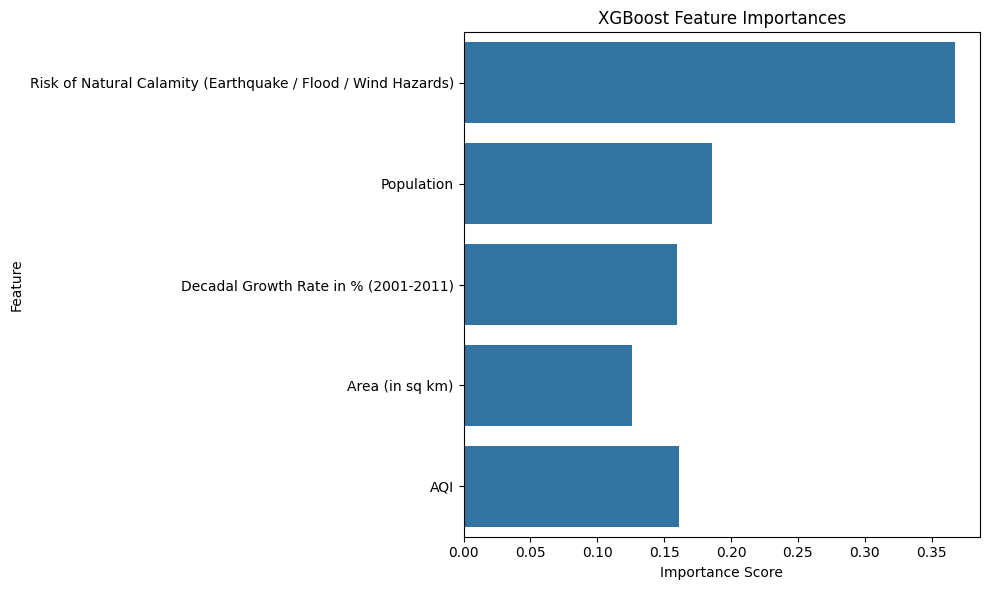

In [ ]:
feature_names = xgb_best_model_features
importances = xgb_best_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


##**Random Forest Classifier Model Building**

In [ ]:
rfc_best_model_features

['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Population',
 'Average Commute Time',
 'Connectivity to Airport (within 100 kms)',
 'Trip Length(KM)']

In [ ]:
rfc_x_train, rfc_x_test, rfc_y_train, rfc_y_test = train_test_splitting(
    x = x[rfc_best_model_features],
    y = y
)

In [ ]:
rfc_bool_cols = ['Connectivity to Airport (within 100 kms)']
rfc_num_cols = [col for col in rfc_best_model_features if col not in rfc_bool_cols]
rfc_num_cols

['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Population',
 'Average Commute Time',
 'Trip Length(KM)']

In [ ]:
rfc_bool_cols_present = [col for col in rfc_bool_cols if col in rfc_best_model_features]
rfc_bool_cols_present

['Connectivity to Airport (within 100 kms)']

In [ ]:
rfc_scaler = StandardScaler()

In [ ]:
rfc_x_train_num = rfc_scaler.fit_transform(rfc_x_train[rfc_num_cols])
rfc_x_test_num = rfc_scaler.transform(rfc_x_test[rfc_num_cols])

In [ ]:
if rfc_bool_cols_present:
    rfc_x_train_bool = rfc_x_train[rfc_bool_cols_present].values
    rfc_x_test_bool = rfc_x_test[rfc_bool_cols_present].values

    rfc_x_train_scaled = np.hstack((rfc_x_train_num, rfc_x_train_bool))
    rfc_x_test_scaled = np.hstack((rfc_x_test_num, rfc_x_test_bool))
else:
    rfc_x_train_scaled = rfc_x_train_num
    rfc_x_test_scaled = rfc_x_test_num

In [ ]:
rfc_x_train_res, rfc_y_train_res = smote.fit_resample(rfc_x_train_scaled, rfc_y_train)
rfc_x_train_res, rfc_y_train_res = undersample.fit_resample(rfc_x_train_res, rfc_y_train_res)

In [ ]:
rfc_x_train_synthetic = add_gaussian_noise(rfc_x_train_res)
rfc_y_train_synthetic = rfc_y_train_res.copy()

In [ ]:
rfc_x_train_noise = add_gaussian_noise(rfc_x_train_res, noise_level=0.05)
rfc_y_train_noise = rfc_y_train_res.copy()

In [ ]:
rfc_x_train_final = np.vstack((rfc_x_train_res, rfc_x_train_synthetic))
rfc_y_train_final = np.hstack((rfc_y_train_res, rfc_y_train_synthetic))
print("Final class balance:", Counter(rfc_y_train_final))

Final class balance: Counter({np.int64(0): 698, np.int64(1): 698})


In [ ]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(rfc_y_train_final), y=rfc_y_train_final)
class_weight_ratio = weights[1] / weights[0]

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [ ]:
rfc_base = RandomForestClassifier(random_state=42)

In [ ]:
rfc_search = RandomizedSearchCV(
    rfc_base,
    param_distributions=param_dist,
    scoring='f1',
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

In [ ]:
rfc_search.fit(rfc_x_train_final, rfc_y_train_final)
rfc_best_model = rfc_search.best_estimator_
print("Best Parameters:", rfc_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced_subsample'}


**After training 5 different models, we found the following to be the best parameters and will be continuing with it:{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}**


In [ ]:
rfc_best_model = RandomForestClassifier(
    n_estimators = 300,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = 20,
    class_weight = 'balanced',
    random_state = 42
)

In [ ]:
rfc_best_model.fit(rfc_x_train_final, rfc_y_train_final)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=300,
                       random_state=42)

In [ ]:
calibrated_rfc = CalibratedClassifierCV(rfc_best_model, cv=5)
calibrated_rfc.fit(rfc_x_train_final, rfc_y_train_final)

CalibratedClassifierCV(cv=5,
                       estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=20,
                                                        n_estimators=300,
                                                        random_state=42))

In [ ]:
y_probs_rfc = calibrated_rfc.predict_proba(rfc_x_test_scaled)[:, 1]

In [ ]:
best_f1 = 0
best_thresh = 0.5
for thresh in np.arange(0.3, 0.6, 0.02):
    preds = (y_probs_rfc > thresh).astype(int)
    score = f1_score(rfc_y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"Best F1 Score: {best_f1:.4f} at threshold: {best_thresh:.2f}")

Best F1 Score: 0.6912 at threshold: 0.30


In [ ]:
rfc_final_preds = (y_probs_rfc > best_thresh).astype(int)

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(rfc_y_test, rfc_final_preds))


Confusion Matrix:
[[134  20]
 [ 22  47]]


In [ ]:
print("\nClassification Report:")
print(classification_report(rfc_y_test, rfc_final_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       154
           1       0.70      0.68      0.69        69

    accuracy                           0.81       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.81      0.81      0.81       223



In [ ]:
precision, recall, _ = precision_recall_curve(rfc_y_test, rfc_final_preds)

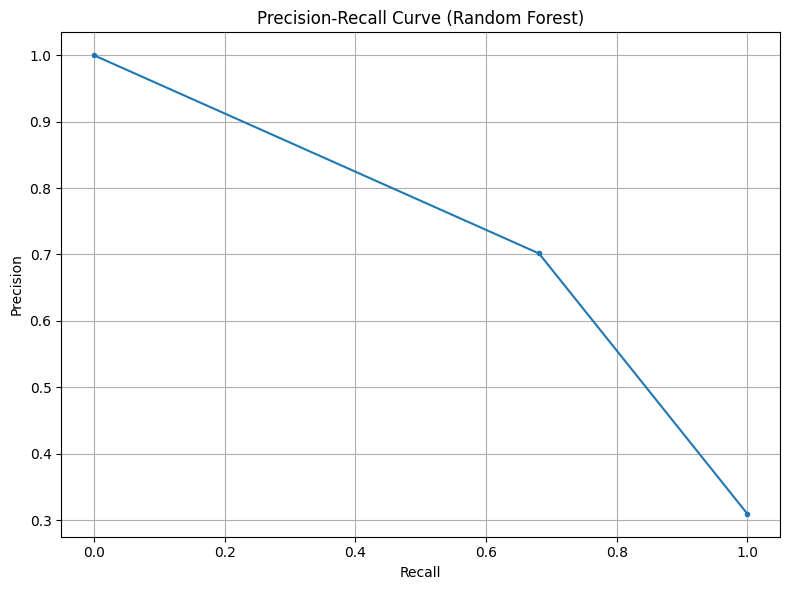

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

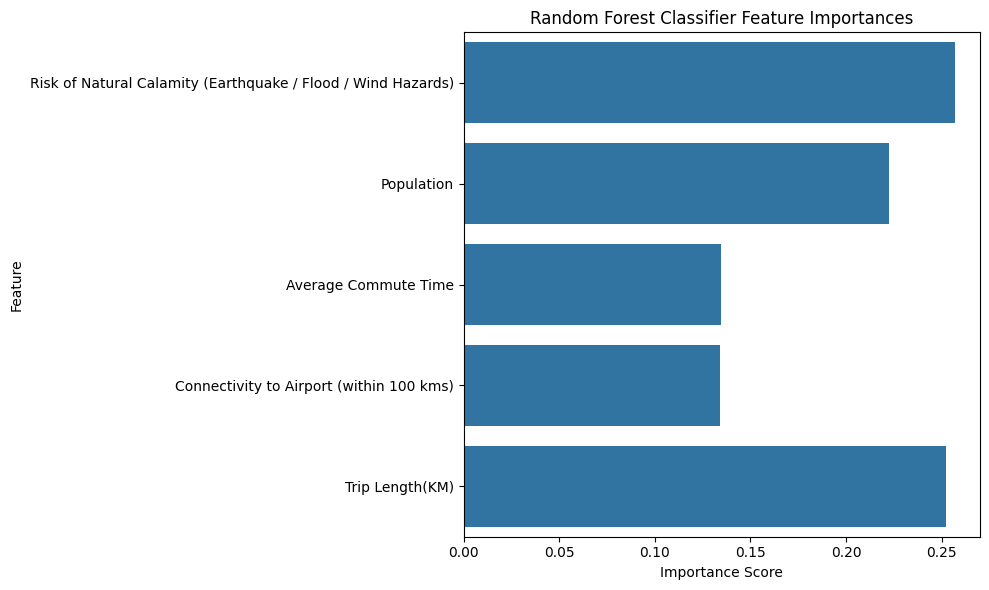

In [ ]:
feature_names = rfc_best_model_features
importances = rfc_best_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest Classifier Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


##**Decision Tree Classifier Model Building**

In [ ]:
dtc_x_train, dtc_x_test, dtc_y_train, dtc_y_test = train_test_splitting(
    x = x[dtc_best_model_features],
    y = y
)

In [ ]:
dtc_bool_cols = ['Connectivity to Airport (within 100 kms)']
dtc_num_cols = [col for col in dtc_best_model_features if col not in dtc_bool_cols]

In [ ]:
dtc_bool_cols_present = [col for col in dtc_bool_cols if col in dtc_best_model_features]
dtc_bool_cols_present

[]

In [ ]:
dtc_scaler = StandardScaler()

In [ ]:
dtc_x_train_num = dtc_scaler.fit_transform(dtc_x_train[dtc_num_cols])
dtc_x_test_num = dtc_scaler.transform(dtc_x_test[dtc_num_cols])

In [ ]:
if dtc_bool_cols_present:
    dtc_x_train_bool = dtc_x_train[dtc_bool_cols_present].values
    dtc_x_test_bool = dtc_x_test[dtc_bool_cols_present].values

    dtc_x_train_combined = np.hstack((dtc_x_train_num, dtc_x_train_bool))
    dtc_x_test_combined = np.hstack((dtc_x_test_num, dtc_x_test_bool))
else:
    dtc_x_train_combined = dtc_x_train_num
    dtc_x_test_combined = dtc_x_test_num

In [ ]:
dtc_x_train_res, dtc_y_train_res = smote.fit_resample(dtc_x_train_combined, dtc_y_train)
dtc_x_train_res, dtc_y_train_res = undersample.fit_resample(dtc_x_train_res, dtc_y_train_res)

In [ ]:
dtc_x_train_synthetic = add_gaussian_noise(dtc_x_train_res, noise_level=0.05)
dtc_y_train_synthetic = dtc_y_train_res.copy()

In [ ]:
dtc_x_train_final = np.vstack((dtc_x_train_res, dtc_x_train_synthetic))
dtc_y_train_final = np.hstack((dtc_y_train_res, dtc_y_train_synthetic))

In [ ]:
print("Final class balance (DTC):", Counter(dtc_y_train_final))

Final class balance (DTC): Counter({np.int64(0): 686, np.int64(1): 686})


In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [ ]:
dtc_base = DecisionTreeClassifier(random_state=42)

In [ ]:
dtc_search = RandomizedSearchCV(
    dtc_base,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

In [ ]:
dtc_search.fit(dtc_x_train_final, dtc_y_train_final)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='f1', verbose=1)

In [ ]:
dtc_best_model = dtc_search.best_estimator_
print("Best Parameters:", dtc_search.best_params_)

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}


**After training 5 different models, we found the following to be the best parameters and will be continuing with it: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}**

In [ ]:
dtc_best_model = DecisionTreeClassifier(
    min_samples_split = 5,
    min_samples_leaf = 2,
    max_features = None,
    max_depth = None,
    criterion = 'entropy',
    random_state = 42
)

In [ ]:
dtc_best_model.fit(dtc_x_train_final, dtc_y_train_final)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [ ]:
calibrated_dtc = CalibratedClassifierCV(dtc_best_model, cv=5)
calibrated_dtc.fit(dtc_x_train_final, dtc_y_train_final)

CalibratedClassifierCV(cv=5,
                       estimator=DecisionTreeClassifier(criterion='entropy',
                                                        min_samples_leaf=2,
                                                        min_samples_split=5,
                                                        random_state=42))

In [ ]:
dtc_y_probs = calibrated_dtc.predict_proba(dtc_x_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0.5
best_metrics = (0, 0)

f1s, precisions, recalls = [], [], []

for thresh in thresholds:
    preds = (dtc_y_probs > thresh).astype(int)
    precision = precision_score(dtc_y_test, preds)
    recall = recall_score(dtc_y_test, preds)
    f1 = f1_score(dtc_y_test, preds)

    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
        best_metrics = (precision, recall)

print(f"\nBest F1 Score: {best_f1:.4f} at threshold: {best_thresh:.2f}")
print(f"Precision of Yes Cases: {best_metrics[0]:.4f}, Recall of Yes Cases: {best_metrics[1]:.4f}")


Best F1 Score: 0.6250 at threshold: 0.55
Precision of Yes Cases: 0.6780, Recall of Yes Cases: 0.5797


In [ ]:
dtc_final_preds = (dtc_y_probs > best_thresh).astype(int)

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(dtc_y_test, dtc_final_preds))


Confusion Matrix:
[[135  19]
 [ 29  40]]


In [ ]:
print("\nClassification Report:")
print(classification_report(dtc_y_test, dtc_final_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       154
           1       0.68      0.58      0.62        69

    accuracy                           0.78       223
   macro avg       0.75      0.73      0.74       223
weighted avg       0.78      0.78      0.78       223



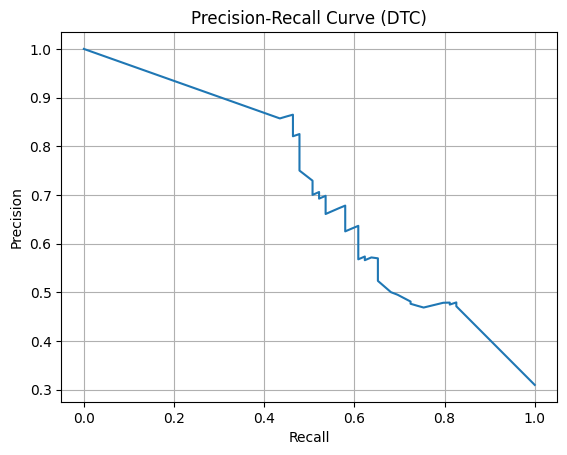

In [ ]:
precision, recall, _ = precision_recall_curve(dtc_y_test, dtc_y_probs)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (DTC)")
plt.grid(True)
plt.show()

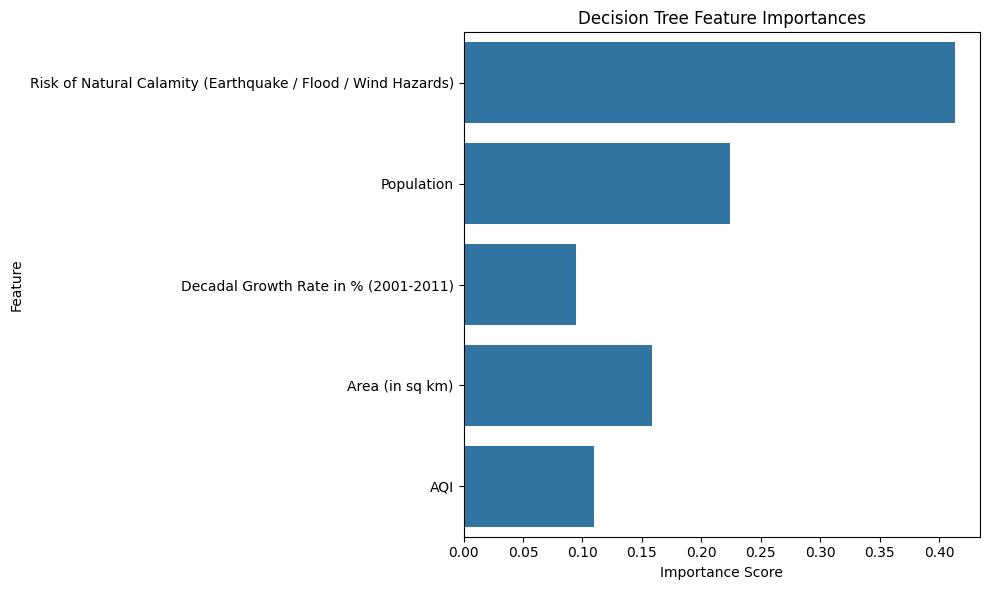

In [ ]:
feature_names = dtc_best_model_features
importances = dtc_best_model.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Decision Tree Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

##**Logistic Regression Model Building**

In [ ]:
logreg_best_model_features

['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
 'Decadal Growth Rate in % (2001-2011)',
 'AQI',
 'Current Infrastructure',
 'Average Commute Time']

In [ ]:
logreg_x_train, logreg_x_test, logreg_y_train, logreg_y_test = train_test_splitting(
    x=x[logreg_best_model_features],
    y=y
)

In [ ]:
logreg_bool_cols = ['Connectivity to Airport (within 100 kms)']
logreg_num_cols = [col for col in logreg_best_model_features if col not in logreg_bool_cols]

In [ ]:
logreg_bool_cols_present = [col for col in logreg_bool_cols if col in logreg_best_model_features]
logreg_bool_cols_present

[]

In [ ]:
logreg_scaler = StandardScaler()

In [ ]:
logreg_x_train_num = logreg_scaler.fit_transform(logreg_x_train[logreg_num_cols])
logreg_x_test_num = logreg_scaler.transform(logreg_x_test[logreg_num_cols])

In [ ]:
if logreg_bool_cols_present:
    logreg_x_train_bool = logreg_x_train[logreg_bool_cols_present].values
    logreg_x_test_bool = logreg_x_test[logreg_bool_cols_present].values

    logreg_x_train_combined = np.hstack((logreg_x_train_num, logreg_x_train_bool))
    logreg_x_test_combined = np.hstack((logreg_x_test_num, logreg_x_test_bool))
else:
    logreg_x_train_combined = logreg_x_train_num
    logreg_x_test_combined = logreg_x_test_num

In [ ]:
logreg_x_train_res, logreg_y_train_res = smote.fit_resample(logreg_x_train_combined, logreg_y_train)
logreg_x_train_res, logreg_y_train_res = undersample.fit_resample(logreg_x_train_res, logreg_y_train_res)

In [ ]:
logreg_x_train_synthetic = add_gaussian_noise(logreg_x_train_res, noise_level=0.05)
logreg_y_train_synthetic = logreg_y_train_res.copy()

In [ ]:
logreg_x_train_final = np.vstack((logreg_x_train_res, logreg_x_train_synthetic))
logreg_y_train_final = np.hstack((logreg_y_train_res, logreg_y_train_synthetic))
print("Final class balance:", Counter(logreg_y_train_final))

Final class balance: Counter({np.int64(0): 678, np.int64(1): 678})


In [ ]:
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
        'C': [0.01, 0.1, 1, 10]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.25, 0.5, 0.75]
    }
]

In [ ]:
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
grid_search_logreg = GridSearchCV(
    logreg_model,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_search_logreg.fit(logreg_x_train_final, logreg_y_train_final)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'liblinear', 'sag', 'saga']},
                         {'C': [0.01, 0.1, 1, 10],
                          'l1_ratio': [0.25, 0.5, 0.75],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='f1', verbose=1)

In [ ]:
best_logreg_model = grid_search_logreg.best_estimator_
print("Best Parameters (Logistic Regression):", grid_search_logreg.best_params_)

Best Parameters (Logistic Regression): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


**After training 5 different models, we found the following to be the best parameters and will be continuing with it: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}**


In [ ]:
best_logreg_model = LogisticRegression(
    C=0.1,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
    )

In [ ]:
best_logreg_model.fit(logreg_x_train_final, logreg_y_train_final)

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
logreg_y_probs = best_logreg_model.predict_proba(logreg_x_test_combined)[:, 1]

In [ ]:
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0
best_metrics = (0, 0)

f1s = []
precisions = []
recalls = []

for thresh in thresholds:
    preds = (logreg_y_probs > thresh).astype(int)
    precision = precision_score(logreg_y_test, preds)
    recall = recall_score(logreg_y_test, preds)
    f1 = f1_score(logreg_y_test, preds)

    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
        best_metrics = (precision, recall)

print(f"\nBest F1 Score: {best_f1:.4f} at threshold: {best_thresh:.2f}")
print(f"Precision of Yes Cases: {best_metrics[0]:.4f}, Recall of Yes Cases: {best_metrics[1]:.4f}")



Best F1 Score: 0.5316 at threshold: 0.45
Precision of Yes Cases: 0.4719, Recall of Yes Cases: 0.6087


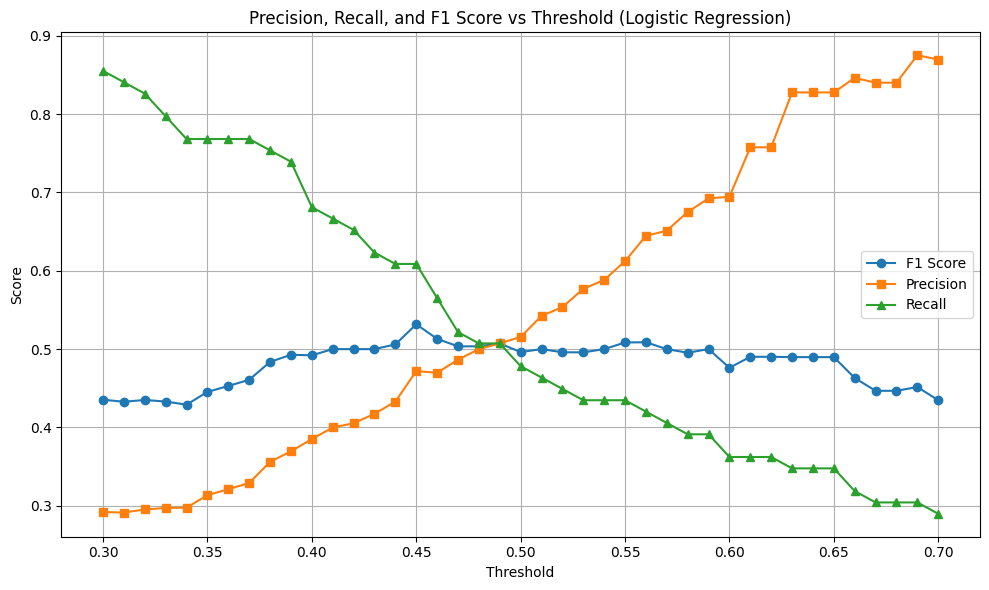

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.plot(thresholds, recalls, label='Recall', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold (Logistic Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
logreg_final_preds = (logreg_y_probs > best_thresh).astype(int)

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(logreg_y_test, logreg_final_preds))


Confusion Matrix:
[[107  47]
 [ 27  42]]


In [ ]:
print("\nClassification Report:")
print(classification_report(logreg_y_test, logreg_final_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       154
           1       0.47      0.61      0.53        69

    accuracy                           0.67       223
   macro avg       0.64      0.65      0.64       223
weighted avg       0.70      0.67      0.68       223



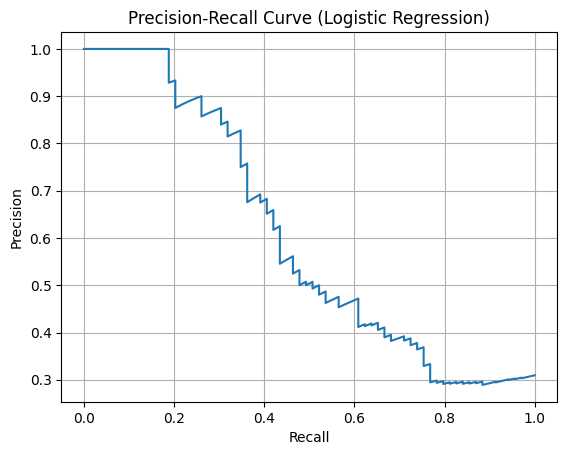

In [ ]:
precision, recall, _ = precision_recall_curve(logreg_y_test, logreg_y_probs)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.grid(True)
plt.show()

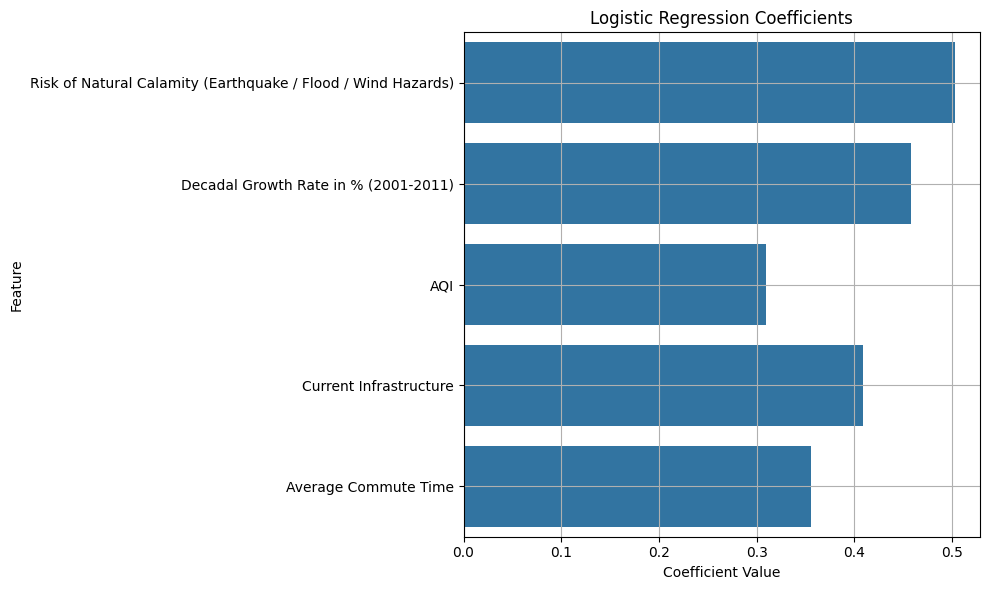

In [ ]:
feature_names = logreg_best_model_features
coefficients = best_logreg_model.coef_[0]

plt.figure(figsize=(10, 6))
sns.barplot(x=coefficients, y=feature_names)
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(True)
plt.show()

##**Non-Linear SVM**

In [ ]:
selected_indices = [x_scaled_cols.index(col) for col in svm_best_model_features]
x_scaled_selected = x_scaled_for_rfe[:, selected_indices]

In [ ]:
svm_x_train, svm_x_test, svm_y_train, svm_y_test = train_test_splitting(
    x = x_scaled_selected,
    y = y
)

In [ ]:
svm_x_train_final, svm_y_train_final = smote.fit_resample(svm_x_train, svm_y_train)
svm_x_train_final, svm_y_train_final = undersample.fit_resample(svm_x_train_final, svm_y_train_final)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 50, 100, 500],
    'gamma': ['scale', 'auto', 1, 0.1, 0.01, 0.001, 0.0001],
    'class_weight': [None, 'balanced']
}

In [ ]:
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=svm_rbf,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search.fit(svm_x_train_final, svm_y_train_final)
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Params: {'gamma': 1, 'class_weight': None, 'C': 100}


**After training 5 different models, we found the following to be the best parameters and will be continuing with it: {'gamma': 1, 'class_weight': None, 'C': 100}**


In [ ]:
svm_rbf = SVC(
    kernel='rbf',
    C=100,
    gamma=1,
    class_weight=None,
    probability=True,
    random_state=42)

In [ ]:
calibrated_svc = CalibratedClassifierCV(estimator=svm_rbf, cv=5)
calibrated_svc.fit(svm_x_train_final, svm_y_train_final)

CalibratedClassifierCV(cv=5,
                       estimator=SVC(C=100, gamma=1, probability=True,
                                     random_state=42))

In [ ]:
y_probs_svm = calibrated_svc.predict_proba(svm_x_test)[:, 1]

In [ ]:
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0
best_metrics = (0, 0)

f1s = []
precisions = []
recalls = []

for thresh in thresholds:
    preds = (y_probs_svm > thresh).astype(int)
    precision = precision_score(svm_y_test, preds)
    recall = recall_score(svm_y_test, preds)
    f1 = f1_score(svm_y_test, preds)

    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh
        best_metrics = (precision, recall)

print(f"\nBest F1 Score: {best_f1:.4f} at threshold: {best_thresh:.2f}")
print(f"Precision: {best_metrics[0]:.4f}, Recall: {best_metrics[1]:.4f}")



Best F1 Score: 0.6395 at threshold: 0.30
Precision: 0.5340, Recall: 0.7971


In [ ]:
svm_final_preds = (y_probs_svm > best_thresh).astype(int)

In [ ]:
print("\nConfusion Matrix:")
print(confusion_matrix(svm_y_test, svm_final_preds))


Confusion Matrix:
[[106  48]
 [ 14  55]]


In [ ]:
print("\nClassification Report:")
print(classification_report(svm_y_test, svm_final_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       154
           1       0.53      0.80      0.64        69

    accuracy                           0.72       223
   macro avg       0.71      0.74      0.71       223
weighted avg       0.78      0.72      0.73       223



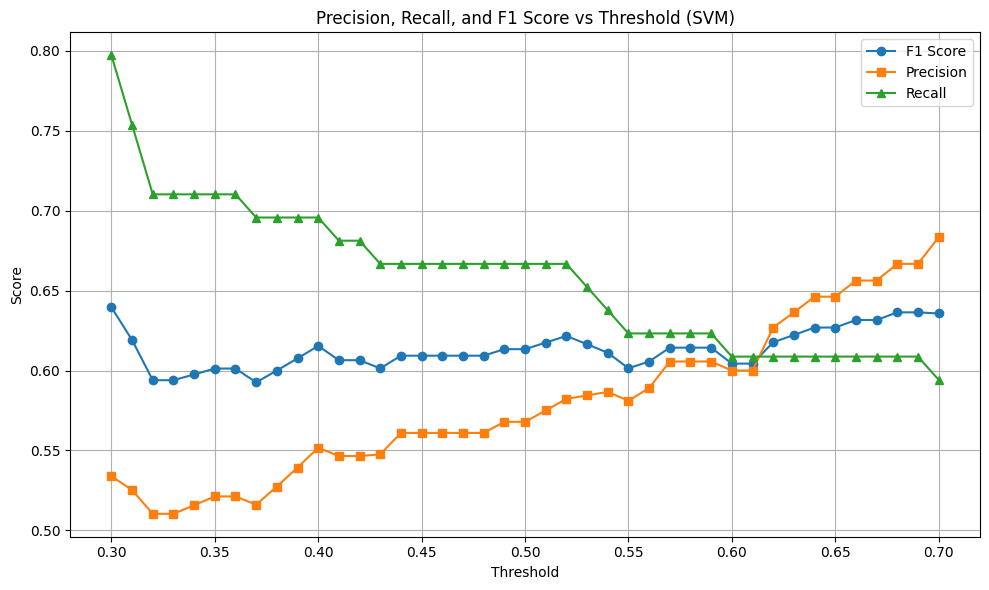

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.plot(thresholds, precisions, label='Precision', marker='s')
plt.plot(thresholds, recalls, label='Recall', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold (SVM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

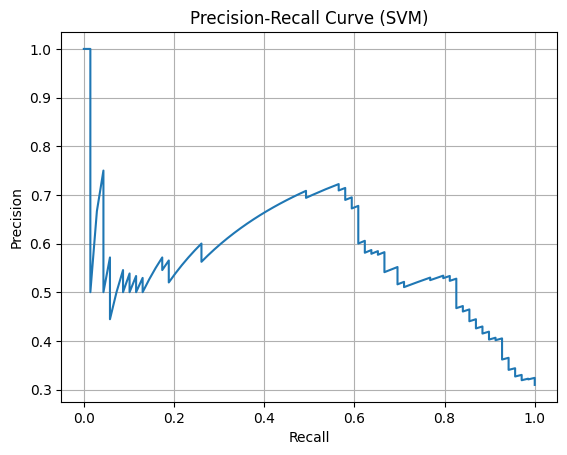

In [ ]:
precision, recall, _ = precision_recall_curve(svm_y_test, y_probs_svm)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SVM)")
plt.grid(True)
plt.show()

In [ ]:
result = permutation_importance(
    calibrated_svc,
    svm_x_test,
    svm_y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

In [ ]:
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

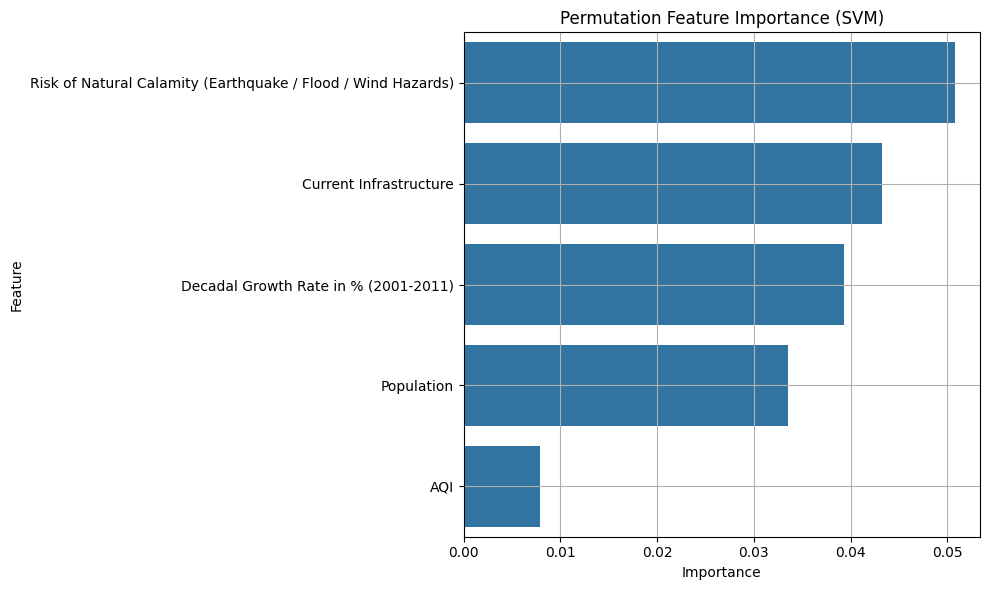

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=np.array(svm_best_model_features)[indices])
plt.title("Permutation Feature Importance (SVM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()

#**Comparing Model Evaluation Parameters**

In [ ]:
def extract_metrics(report):
    return {
        'Precision (0)': report['0']['precision']*100,
        'Recall (0)': report['0']['recall']*100,
        'F1-score (0)': report['0']['f1-score']*100,
        'Precision (1)': report['1']['precision']*100,
        'Recall (1)': report['1']['recall']*100,
        'F1-score (1)': report['1']['f1-score']*100,
        'Overall Model Accuracy': report['accuracy']*100
    }

In [ ]:
xgb_report = classification_report(xgb_y_test, xgb_final_preds, output_dict=True)
rfc_report = classification_report(rfc_y_test, rfc_final_preds, output_dict=True)
dtc_report = classification_report(dtc_y_test, dtc_final_preds, output_dict=True)
logreg_report = classification_report(logreg_y_test, logreg_final_preds, output_dict=True)
svm_report = classification_report(svm_y_test, svm_final_preds, output_dict=True)

In [ ]:
comparison_df = pd.DataFrame({
    'XGBoost': extract_metrics(xgb_report),
    'Random Forest': extract_metrics(rfc_report),
    'Decision Tree': extract_metrics(dtc_report),
    'Logistic Regression': extract_metrics(logreg_report),
    'SVM (RBF)': extract_metrics(svm_report)
}).T

In [ ]:
comparison_df_sorted = comparison_df.sort_values(by=['Precision (1)',
                                                     'Recall (1)', 'Overall Model Accuracy'], ascending=False)

In [ ]:
comparison_df_sorted.style.format(precision=4).set_table_attributes("style='border:1px solid black'").set_table_styles(
    [{'selector': 'th', 'props': [('border', '1px solid black')]},
     {'selector': 'td', 'props': [('border', '1px solid black')]}]
).set_caption("Model Comparison Table (Sorted by Precision, Recall, and Accuracy) in Percentage")

,Precision (0),Recall (0),F1-score (0),Precision (1),Recall (1),F1-score (1),Overall Model Accuracy
Random Forest,85.8974,87.0130,86.4516,70.1493,68.1159,69.1176,81.1659
Decision Tree,82.3171,87.6623,84.9057,67.7966,57.9710,62.5000,78.4753
XGBoost,82.0988,86.3636,84.1772,65.5738,57.9710,61.5385,77.5785
SVM (RBF),88.3333,68.8312,77.3723,53.3981,79.7101,63.9535,72.1973
Logistic Regression,79.8507,69.4805,74.3056,47.1910,60.8696,53.1646,66.8161


#**Model Demonstration**

In [ ]:
def get_input():
    risk_map = {'low': 0, 'medium': 1, 'high': 2}
    airport_map = {'yes': True, 'no': False}

    while True:
        risk_input = input("Enter the Risk of Calamity (Low / Medium / High): ").strip().lower()
        if risk_input in risk_map:
            break
        print("Invalid input. Please enter 'Low', 'Medium', or 'High'.")

    risk = risk_map[risk_input]

    while True:
        try:
            population = int(input("Enter the current Population: "))
            break
        except ValueError:
            print("Invalid number. Try again.")

    while True:
        try:
            commute = float(input("Enter the Average Commute Time (in minutes): "))
            break
        except ValueError:
            print("Invalid number. Try again.")

    while True:
        try:
            trip = float(input("Enter the Average Trip Distance (in KM): "))
            break
        except ValueError:
            print("Invalid number. Try again.")

    while True:
        airport_input = input("Is there an airport within 100 kms? (Yes / No): ").strip().lower()
        if airport_input in airport_map:
            break
        print("Invalid input. Please enter 'Yes' or 'No'.")

    airport = airport_map[airport_input]

    return [[risk, population, commute, airport, trip]]


In [ ]:
def predict(user_input):
    df_input = pd.DataFrame(user_input, columns=[
        'Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
        'Population',
        'Average Commute Time',
        'Connectivity to Airport (within 100 kms)',
        'Trip Length(KM)'
    ])

    num_cols = ['Risk of Natural Calamity (Earthquake / Flood / Wind Hazards)',
                'Population', 'Average Commute Time', 'Trip Length(KM)']
    bool_cols = ['Connectivity to Airport (within 100 kms)']


    df_num = rfc_scaler.transform(df_input[num_cols])
    df_bool = df_input[bool_cols].values
    final_input = np.hstack((df_num, df_bool))

    prob = calibrated_rfc.predict_proba(final_input)[:, 1]
    prediction = int(prob[0] > best_thresh)

    if prediction == 1:
        print("\nThe district needs a Metro line.")
    else:
        print("\nThe district does not need a Metro line.")


In [ ]:
inputs = get_input()
predict(inputs)

The above data is similar to Ambedkar Nagar in Uttar Pradesh, who has no metro. We increased the average distance and commute time to see if it would predict it right or not

Ambedkar Nagar values:
low 239799 15 10 no

In [ ]:
inputs = get_input()
predict(inputs)

In [ ]:
inputs = get_input()
predict(inputs)

In [ ]:
inputs = get_input()
predict(inputs)

#**Model Extraction**

In [ ]:
pickle.dump(calibrated_rfc, open('predictor.pkl', 'wb'))

In [ ]:
  with open('threshold.txt', 'w') as f:
      f.write(str(best_thresh))

In [ ]:
pickle.dump(rfc_scaler, open('scaler.pkl', 'wb'))

In [ ]:
!pip install flask-ngrok
!pip install flask-ngrok --upgrade
!pip install flask==0.12.2
!pip install flask --upgrade

from markupsafe import Markup
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
import pickle
import numpy as np
import os
app = Flask(__name__)
run_with_ngrok(app)
current_dir = os.getcwd()

model_path = os.path.join(current_dir, 'predictor.pkl')
scaler_path = os.path.join(current_dir, 'scaler.pkl')


with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json

        risk_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
        risk = risk_mapping.get(data['risk'], 0)

        population = float(data['population'])
        commute = float(data['commute'])
        airport = 1 if data['airport'] == 'Yes' else 0
        trip = float(data['trip'])

        features = np.array([risk, population, commute, airport, trip]).reshape(1, -1)

        scaled_features = scaler.transform(features)
        prediction = model.predict(scaled_features)

        return jsonify({'prediction': prediction[0]})

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: flask
    Found existing installation: Flask 0.12.2
    Uninstalling Flask-0.12.2:
      Successfully uninstalled Flask-0.12.2


FileNotFoundError: [Errno 2] No such file or directory: '/content/predictor.pkl'